# Computer Vision API example

### Instructions for Jupyter notebook usage
* This is a jupyter notebook so that means interactive coding in a browser
* You want to run each grey cell (the Python, in this case, code) in order and one at a time
* Make sure each code cell has finished running (a number will appear inside the In[] when the cell is done)
* You can also see if the notebook is running by looking for a filled in circle in the upper right corner of this notebook
* Feel free to change code (even if you don't know Python)
* There are many helper methods in this notebook so don't worry if you don't understand
* Have fun with this and save the notebook often :)

## Let's take care of some installs

In [1]:
# !conda install --no-deps -c menpo opencv=2.4.11 --yes

In [2]:
# ! pip uninstall matplotlib --yes

In [3]:
# ! pip install matplotlib -q

## Let's import some modules

In [4]:
import time 
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function
import json
from urlparse import urlparse
from urllib import urlencode
from urllib2 import Request, urlopen
from httplib import HTTPSConnection 

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

## Now to set some constants

* The Cognitive Services keys (grabbing the computer vision one)

In [5]:
# Paste in your API key here to the 'subscription_key' variable or create a config.json

f = urlopen('https://gist.githubusercontent.com/michhar/03b38c07be7a3a26aa83005e4b38d4f6/raw/6a214f22f63f2e28905f48c991438736bcc77eef/config.json')

CONFIG=json.loads(f.read())
# grab key from json in config
subscription_key = CONFIG['subscription_key_computer_vision']

* **<font color=green>The Cognitive Services Computer Vision web service request url</font>**

In [6]:
# Variables

# Make sure to take your Endpoint from Overview page of API in Azure Portal
_url = 'https://westeurope.api.cognitive.microsoft.com/vision/v1.0/describe' # change the ending to 'analyze' or 'describe'
_key = subscription_key

_maxNumRetries = 10

## Helper functions

In [7]:
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:
        # Use the requests library to make the POST call
        response = requests.request( 'post', 
                                    _url, 
                                    json=json, 
                                    data=data, 
                                    headers=headers, 
                                    params=params )

        if response.status_code == 429: 
            print( "Message: %s" % ( response.json()['error']['message'] ) )
            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break
                
        # We have a successful response, but let's do some tests on response data
        elif response.status_code == 200 or response.status_code == 201:
            if 'content-length' in response.headers and \
                int(response.headers['content-length']) == 0: 
                    
                result = None
                
            elif 'content-type' in response.headers and \
                isinstance(response.headers['content-type'], str):
                    
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None
                    
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )

        break
        
    return result

In [8]:
def renderResultOnImage( result, img ):
    """Display the obtained results onto the input image"""

    if 'description' in result:
        descrip = result['description']['captions'][0]['text']
        print(descrip)
        cv2.putText(img, descrip, (30,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 3)
    if 'categories' in result:
        # Put a rectangle around the image to reflect accent colors
        R = int(result['color']['accentColor'][:2],16)
        G = int(result['color']['accentColor'][2:4],16)
        B = int(result['color']['accentColor'][4:],16)
        if img is not None:
            cv2.rectangle(img,(0,0), (img.shape[1], img.shape[0]), color=(R,G,B), thickness=25)

        categoryName = sorted(result['categories'], key=lambda x: x['score'])[0]['name']
        print(categoryName)
        cv2.putText(img, categoryName, (30,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3)

## Analysis of an image retrieved via URL

* **<font color=green>Place an image URL here in the `urlImage` variable (must be a good quality, large image)</font>**

Input requirements:
* Supported image formats: JPEG, PNG, GIF, BMP.
* Image file size must be less than 4MB.
* Image dimensions should be greater than 50 x 50.

In [9]:
urlImage = 'http://gb.fotolibra.com/images/previews/392412-pair-of-swans-at-stanborough-park.jpeg'
# urlImage = 'you own url'

a swan swimming in a body of water


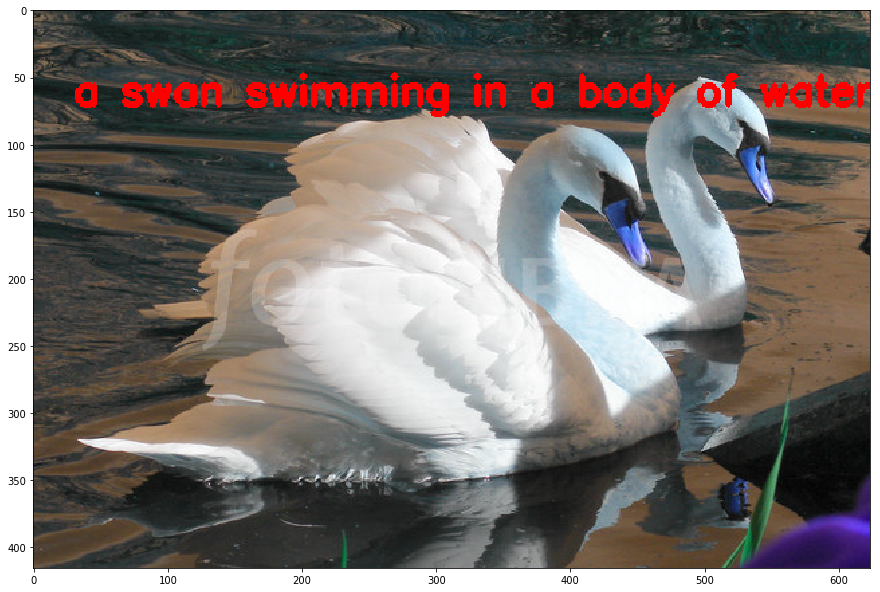

In [10]:
from IPython.display import display, Image


# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage } 
data = None

result = processRequest(json, data, headers, params)

if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), 
                     dtype=np.uint8 )
    
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)

    renderResultOnImage(result, img)
    
    if img is not None:
        plt.subplots(figsize=(15, 20))
        plt.imshow(img)
    else:
        img = Image(url=urlImage, embed=False)
        display(img)


### EXERCISE

In [11]:
# try changing the word 'describe' to 'analyze' in the _url (web service url for REST api) cell towards the beginning